<a href="https://colab.research.google.com/github/tsancode/Population5/blob/miftarj-model/Population5%20Update%20Preliminary_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import package yg diperlukan

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import requests
from io import StringIO

from tensorflow import keras
from tensorflow import nn

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


Import data

In [ ]:
orig_url2='https://drive.google.com/file/d/1BBmMNqARjiuM71WtrldCJ8WZesmfs14v/view?usp=sharing'

file_id2 = orig_url2.split('/')[-2]
dwn_url2='https://drive.google.com/uc?export=download&id=' + file_id2
url2 = requests.get(dwn_url2).text
csv_raw2 = StringIO(url2)
df2 = pd.read_csv(csv_raw2)

Exploratory

In [ ]:
df2.head()

,tahun,wil_id,wilayah,usia_prod
0,2013,1,ADM. KEPULAUAN SERIBUKEPULAUAN SERIBU SELATANP...,1846
1,2013,2,ADM. KEPULAUAN SERIBUKEPULAUAN SERIBU SELATANP...,1520
2,2013,3,ADM. KEPULAUAN SERIBUKEPULAUAN SERIBU SELATANP...,3336
3,2013,4,ADM. KEPULAUAN SERIBUKEPULAUAN SERIBU UTARAPUL...,4396
4,2013,5,ADM. KEPULAUAN SERIBUKEPULAUAN SERIBU UTARAPUL...,1446


In [ ]:
df2.shape

(2403, 4)

In [ ]:
df2['tahun'] = pd.to_datetime(df2['tahun'], format='%Y') 

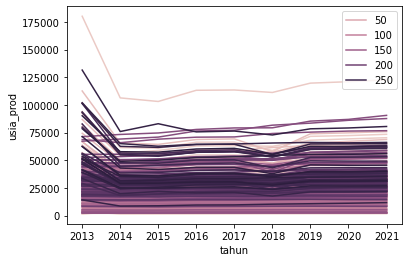

In [ ]:

sns.lineplot(data = df2, x = 'tahun', y = 'usia_prod', hue = 'wil_id')
plt.legend(loc='upper right')
plt.show()


Model

In [ ]:
window = 267

In [ ]:
# This value is the window size we are using
index = window

feature, target = [], []

while(index < df2.shape[0]):
    feature.append(df2.iloc[index - window: index]['usia_prod'].to_numpy())
    target.append(df2.iloc[index][['usia_prod', 'tahun']].to_numpy())
    index = index + 1
feature = np.array(feature)
target = np.array(target)   

In [ ]:
size_test = int(df2['tahun'].value_counts().index.shape[0] * 0.8)
separation_date = df2['tahun'].value_counts().index.sort_values()[size_test]

In [ ]:
x_train, y_train, x_test, y_test = [], [], [], []
for i,t in enumerate(target):
    if t[1] < separation_date:
        x_train.append(feature[i])
        y_train.append(target[i][0])
    else:
        x_test.append(feature[i])
        y_test.append(target[i][0])

In [ ]:
x_train, x_test = np.array(x_train), np.array(x_test)
y_train, y_test = np.array(y_train).reshape(-1, 1), np.array(y_test).reshape(-1, 1)

In [ ]:
scaler_feature = StandardScaler()
scaler_feature.fit(x_train)
x_train = scaler_feature.transform(x_train)
x_test = scaler_feature.transform(x_test)

# Reshaping features for the LSTM
x_train, x_test = x_train.reshape(-1,window,1), x_test.reshape(-1,window,1)

scaler_target = StandardScaler()
scaler_target.fit(y_train)
y_train = scaler_target.transform(y_train)
y_test = scaler_target.transform(y_test)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units = 128, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.LSTM(units = 128))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 267, 128)          66560     
                                                                 
 dropout_2 (Dropout)         (None, 267, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
51/51 [==============================] - 36s 645ms/step - loss: 0.8732 - val_loss: 0.9210
Epoch 2/10
51/51 [==============================] - 31s 604ms/step - loss: 0.7338 - val_loss: 0.8248
Epoch 3/10
51/51 [==============================] - 31s 604ms/step - loss: 0.6997 - val_loss: 0.8066
Epoch 4/10
51/51 [==============================] - 32s 631ms/step - loss: 0.6865 - val_loss: 0.7754
Epoch 5/10
51/51 [==============================] - 31s 610ms/step - loss: 0.6997 - val_loss: 0.7819
Epoch 6/10
51/51 [==============================] - 31s 611ms/step - loss: 0.7014 - val_loss: 0.7842
Epoch 7/10
51/51 [==============================] - 31s 611ms/step - loss: 0.6623 - val_loss: 0.7341
Epoch 8/10
51/51 [==============================] - 32s 629ms/step - loss: 0.6729 - val_loss: 0.7470
Epoch 9/10
51/51 [==============================] - 31s 610ms/step - loss: 0.6453 - val_loss: 0.7205
Epoch 10/10
51/51 [==============================] - 31s 608ms/step - loss: 0.6223 - val_lo

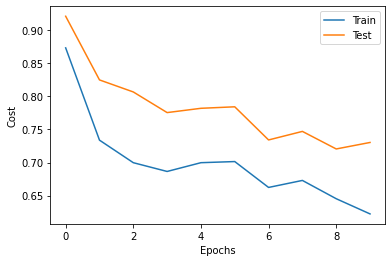

In [ ]:
# Function to print the results of the fit process
def print_loss(result):
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.show()

print_loss(result)

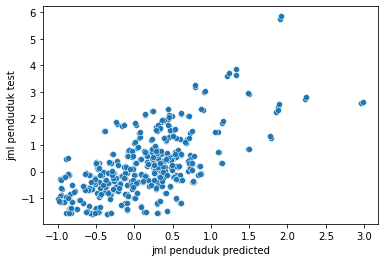

In [ ]:
y_predicted = model.predict(x_test)

ax = sns.scatterplot(x=y_predicted[:,0], y=y_test[:,0])
ax.set_ylabel('jml penduduk test')
ax.set_xlabel('jml penduduk predicted')
plt.show()

In [ ]:
y_predicted = scaler_target.inverse_transform(y_predicted)

In [ ]:
diff = y_predicted - y_test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 946276680.44028
MAE: 29166.71825247825
RMSE: 30761.6104981563
